# MulR variation with PSR

In [1]:
from utils import * 

Using TensorFlow backend.


In [2]:
nltk_tokenizer = RegexpTokenizer("\\#+[\\w_]+[\\w\\'_\\-]*[\\w_]+|@[\\w_]+|[a-zA-Z'ÁÉÍÓÚáéíóúñÑüÜ]+-*[a-zA-Z'ÁÉÍÓÚáéíóúñÑüÜ]+|[a-zA-Z'ÁÉÍÓÚáéíóúñÑüÜ]+|[<>]?[:;=8][\\-o\\*\\']?[\\)\\]\\(\\[oOdDpP/\\:\\}\\{@\\|\\\\3\\*]|[\\)\\]\\(\\[oOdDpP/\\:\\}\\{@\\|\\\\3\\*][\\-o\\*\\']?[:;=8][<>]?|[.]+|[/,$?:;!()&%#=+{}*~.]+")

In [4]:
# Loading training data
PATH = '../../Data/train.csv' 
df  = pd.read_csv(PATH,encoding='utf-8',header=None)
Xss_train = df[0]
Xss_time_train = df[1] # This value is useless in this method
Ys_train = df[2]
print("Training conversations: ",Xss_train.shape," Training labels: ",Ys_train.shape)
print()

#############################################################

# Loading training data
PATH = '../../Data/test.csv'
df  = pd.read_csv(PATH,encoding='utf-8',header=None)
Xss_test = df[0]
Xss_time_test = df[1]# This value is useless in this method
Ys_test = df[2]
print("Testing conversations: ",Xss_test.shape," Testing labels: ",Ys_test.shape)
print()

Training conversations:  (66927,)  Training labels:  (66927,)

Testing conversations:  (155128,)  Testing labels:  (155128,)



,0,1,2
0,bugmail: [Bug 6978] New: Mark eof-terminated s...,15:24,0
1,back ok babe what happend babe dog wanted out ...,19:28,1
2,hello boys are shit that they are hi sorry i w...,03:10,0
3,hi hii hous it going? w r u from ?,10:36,0
4,"hello there how are ya? hey so, where are you ...",14:11,0


# Simple preprocessing to the data

In [4]:
# Processing the training 100% of the documents
clean_tr_txt = [] 
for document in Xss_train:
    new_document = [document.lower()]
    clean_tr_txt += new_document
tr_txt = clean_tr_txt
print("Training documents ...",len(tr_txt))

# Processing the testing 100% of the documents
clean_te_txt = [] 
for document in Xss_test:
    new_document = [document.lower()]
    clean_te_txt += new_document
te_txt = clean_te_txt
print("Testing documents ...",len(te_txt)) # te_txt contine 100% de la info

Training documents ... 66927
Testing documents ... 155128


In [5]:
# Creating TR with sklearn 
vectorizer = CountVectorizer(min_df = 10) 
X = vectorizer.fit_transform(tr_txt)
print("Vocabulary : ",len(vectorizer.get_feature_names()))
vocabulary = vectorizer.get_feature_names()
TR = X.toarray()
print("TR: ", TR.shape)
print("TR[0,:10]: ", str(TR[0,:100])) 


X2 = vectorizer.transform(te_txt)
TE = X2.toarray()
print("TE: ", TE.shape)

saving_pkl(vectorizer,"Savings/vectorizer.pkl")

del vectorizer,X,X2
gc.collect()

Vocabulary :  14656
TR:  (66927, 14656)
TR[0,:10]:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
TE:  (155128, 14656)


0

# Replacing the embeddings with the PSR method

In [6]:
def PSR_weight_schema(documents,labels,vocabulary):
    '''
    Args:
        documents : ##Train## documents tokenized
        labels : groomer non-groomer
        vocabulary : list of unique tokens
    Outputs:
        PSR --> words_weights : dic[token] = [NG,G]
    '''
    number_classes = 2
    
    # Inicialize the w_tokens dictionary
    words_weights = dict() 
    for v in vocabulary:
        words_weights[v] =  [0,0]
        
    print("len(vocabulary): ",len(vocabulary)," len(words_weights): ",len(words_weights))
    N = len(documents)
    
    # Calculating frequency (TF) for each token for each class
    for label,document in tqdm(zip(labels,documents),total=len(labels)):
        
        document = document.split()
        # Group each unique token and its frequency Exemp: counter[hi] = 45
        counter = Counter(document)
        for token in np.unique(document):
            if token not in vocabulary:
                continue 
            
            '''
            Normal tf
            '''
            tf = counter[token]
            w_token = np.log2((1+ (tf / len(document))))
            words_weights[token][label] += w_token # Only give weights to tokens that belong to the vocabulary (obtain with train set)


    df = pd.DataFrame.from_dict(words_weights,orient = 'index')
    X = df.values
    # Normalization 1)
    X_std = X / (X.sum(axis=0,keepdims=True)) 
    # Normalization 2)
    X_std = X_std / (X_std.sum(axis=1,keepdims=True)) 
    id = 0
    for key,values in words_weights.items():
        words_weights[key] = np.nan_to_num(X_std[id])
        id += 1
 
    return words_weights


In [7]:
#words_weights = PSR_weight_schema(tr_txt,np.asarray(Ys_train),vocabulary)
#saving_pkl(words_weights,"Savings/words_weights_psr")
words_weights = loading_pkl("Savings/words_weights_psr")

In [8]:
voc_size = len(vocabulary)
DTR = np.zeros((voc_size, 2), dtype=np.float)
for e in range(0,voc_size):
    DTR[e] = words_weights[vocabulary[e]]
print(DTR.shape," ",TR.shape)
print(DTR[40])

(14656, 2)   (66927, 14656)
[0. 0.]


In [9]:
def BoC(TR, DTR, codebook):
    
    code, dist = vq.vq(DTR, codebook)
    new_word_metaword = {}
    for index in range(0,TR.shape[1]): 
        new_word_metaword[index] = code[index] 

    TR_DDR = []
    for tr_doc in TR:
        doc = []
        for w in np.nonzero(tr_doc)[0]:
            for occurrence in range(int(tr_doc[w])):
                doc += [new_word_metaword[w]]
        histogram_of_metawords, bin_edges = histogram(doc, bins=range(len(codebook) + 1))
        TR_DDR += [histogram_of_metawords]

    TR_DDR = np.asarray(TR_DDR)
    TR_DDR=preprocessing.normalize(TR_DDR, norm='l1')
    return TR_DDR

start = time.time()
R = [10, 50, 100, 500,1000]
codebooks = []
for r in R:
    clusterer = KMeans(n_clusters=r, n_jobs=4, random_state=1)
    clusterer.fit(DTR)
    codebook = clusterer.cluster_centers_
    codebooks += [codebook]
    
TR_DDR = BoC(TR, DTR, codebooks[0])
for i in range(1, len(codebooks)):
    TR_DDR = np.concatenate((TR_DDR, BoC(TR, DTR, codebooks[i])), axis=1)

end = time.time()
print(end - start)

142.91493153572083


In [10]:
print(TR_DDR.shape)
print(TR_DDR[0])

(66927, 1660)
[0.15142857 0.08285714 0.10571429 ... 0.         0.         0.        ]


# Testing set

In [11]:
TE_DDR = BoC(TE, DTR, codebooks[0])
for i in range(1, len(codebooks)):
    TE_DDR = np.concatenate((TE_DDR, BoC(TE, DTR, codebooks[i])), axis=1)


print(TE_DDR.shape)
print(TE_DDR[0]) 

(155128, 1660)
[0.25473322 0.04991394 0.10499139 ... 0.         0.         0.00172117]


# Training the SVM classifier

In [12]:
# Transform labels into arrays
Y_train = np.asarray(Ys_train)
Y_test = np.asarray(Ys_test)
print(Y_train.shape," ",Y_test.shape)

# Training the classfier
svr = svm.LinearSVC(class_weight='balanced')
grid=svr
grid.fit(TR_DDR, Y_train) 

# Obtaining the predictions
y_pred = grid.predict(TE_DDR)

# Performing F1 mesure of the positive (groomer) class

f1_g = np.round(metrics.f1_score(Y_test,y_pred,average='binary',pos_label=1),4)
print("F1 mesure with 100% of the information: ",f1_g)

(66927,)   (155128,)
F1 mesure with 100% of the information:  0.4257


# Online stage
## Simulating predictions with different percentage of the conversations

In [13]:
def get_percentage_document(documents,retains):

    info_documents = []
    
    # Tokenize every single document and saving them in a matrix, we save the size of the doc to.
    start = time.time()
    for document in tqdm(documents):
        document_tokenize = nltk.word_tokenize(document)
        document_size = len(document_tokenize)
        info_documents.append([document_size,document_tokenize])
    end = time.time()
    print('Time: ',end-start)
    # Creating a set of documents, each of then with different percentages (%)
    final_documents = []
    for percent in retains:
        
        print("---------------------------------------- ",percent," ---------------------------------------------")
        reduce_documents = []
        if retains != 1:
            # Iteraits each doc and take only (%)
            for element in info_documents:
                document_size = element[0]
                document_tokenize = element[1]
                num_terms = round(document_size * percent)
                reduce_doc = document_tokenize[:num_terms]
                reduce_doc = ' '.join(reduce_doc)
                reduce_doc = reduce_doc.lower()
                reduce_documents.append(reduce_doc)
        else:
            print("100% of info") # In this case, we take everything
            for element in info_documents:
                document_size = element[0]
                document_tokenize = element[1]
                #num_terms = round(document_size * percent)
                reduce_doc = document_tokenize[:document_size] # In this case, we take everything
                reduce_doc = ' '.join(reduce_doc)
                reduce_doc = reduce_doc.lower()
                reduce_documents.append(reduce_doc)
        final_documents.append(reduce_documents)

    # final_documents= [[all_docs(1%)][all_docs(2%)][all_docs(3%)][...][all_docs(100%)]]
    return final_documents

In [14]:
retains = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#final_documents = get_percentage_document(Xss_test,retains)
#saving_pkl(final_documents,"Savings/finalDocuments.pkl")
final_documents = loading_pkl("Savings/finalDocuments.pkl")
print(len(final_documents[0])," ",len(final_documents[9]))

155128   155128


# Preprocessing each chunk

In [15]:
start = time.time()
TE_DDRs = []
# Iterates over each chunk of text
for te,percent in zip(final_documents,retains):
    print("---------------------------------------- ",percent," ---------------------------------------------")
    vectorrizer_oficial = loading_pkl("Savings/vectorizer.pkl")
    X2 = vectorrizer_oficial.transform(te)
    TE = X2.toarray()
    print("TE: ", TE.shape)
    del X2,vectorrizer_oficial
    gc.collect()
    TE_DDR = BoC(TE, DTR, codebooks[0])
    for i in range(1, len(codebooks)):
        TE_DDR = np.concatenate((TE_DDR, BoC(TE, DTR, codebooks[i])), axis=1)
    print("TE_DDR: ",TE_DDR.shape)
    TE_DDRs += [TE_DDR]

end = time.time()
print(end - start)
print(len(TE_DDRs))

----------------------------------------  0.1  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.2  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.3  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.4  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.5  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.6  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------------  0.7  ---------------------------------------------
TE:  (155128, 14656)
TE_DDR:  (155128, 1660)
----------------------------------

# Predictions with partial information

In [16]:
retains = [None,10,20,30,40,50,60,70,80,90,100]
svr = svm.LinearSVC(class_weight='balanced')
grid=svr
grid.fit(TR_DDR, Y_train) 
print("RESULTS PER CHUNK: ")
hist_f=[]

i=1
for TE_DDR in TE_DDRs:
    
    print("CLASSIFICATION FOR CHUNK:", i)
    y_pred = grid.predict(TE_DDR)

    f1_g = np.round(metrics.f1_score(Y_test,y_pred,average='binary',pos_label=1),4)
    print("F1 mesure with ",retains[i], "% of the information available: ",f1_g)
    print("="*50)

    hist_f.append(f1_g)
    i += 1

RESULTS PER CHUNK: 
CLASSIFICATION FOR CHUNK: 1
F1 mesure with  10 % of the information available:  0.0937
CLASSIFICATION FOR CHUNK: 2
F1 mesure with  20 % of the information available:  0.1314
CLASSIFICATION FOR CHUNK: 3
F1 mesure with  30 % of the information available:  0.1737
CLASSIFICATION FOR CHUNK: 4
F1 mesure with  40 % of the information available:  0.2136
CLASSIFICATION FOR CHUNK: 5
F1 mesure with  50 % of the information available:  0.2522
CLASSIFICATION FOR CHUNK: 6
F1 mesure with  60 % of the information available:  0.2892
CLASSIFICATION FOR CHUNK: 7
F1 mesure with  70 % of the information available:  0.3302
CLASSIFICATION FOR CHUNK: 8
F1 mesure with  80 % of the information available:  0.3597
CLASSIFICATION FOR CHUNK: 9
F1 mesure with  90 % of the information available:  0.3948
CLASSIFICATION FOR CHUNK: 10
F1 mesure with  100 % of the information available:  0.4247


# Testing with SGD testing corpus

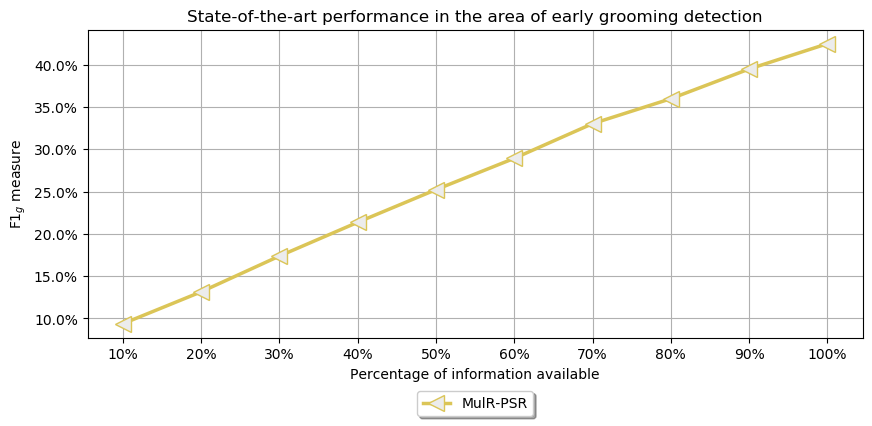

In [17]:
results = hist_f.copy()
plotting(results,"#DBC557","<","MulR-PSR")

In [23]:
def pre_processing(doc_partial):
    new_doc = list()
    for doc in doc_partial:
        new_doc.append(doc.lower())            
    return new_doc

In [26]:
def calculating_preds(PATH,num_chunks):

    print("Extracting conversations")
    data_set = loading_pkl(PATH) 
    matrix_text,labels,start_time_conversations,number_participants,matrix = data_set
    print("%text: ",(matrix_text.shape))
    print("labels: ",len(labels),labels[0])
    print("start_time_conversations: ",len(start_time_conversations),start_time_conversations[0])
    print("# participants: ",(number_participants.shape),number_participants[0][0])
    print("%int matrix: ",(matrix.shape),matrix[0][0])
    print("+"*40)
    
    
    probs = list()
    TE_DDRs = []
    retains = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        
    for  chunk in range(num_chunks):
        doc_partial = matrix_text[:,chunk]
        Y_partial = labels
        groomer_before = sum([1 for i in Y_partial if i ==1])
        
        '''Preprocessing'''
        doc_partial = pre_processing(doc_partial)
        Y_partial = np.asarray(Y_partial)
        groomer_after = sum([1 for i in Y_partial if i ==1])        
        
        vectorrizer_oficial = loading_pkl("Savings/vectorizer.pkl")
        X2 = vectorrizer_oficial.transform(doc_partial)
        TE = X2.toarray()
        print("TE: ", TE.shape)
        del X2,vectorrizer_oficial
        gc.collect()
        TE_DDR = BoC(TE, DTR, codebooks[0])
        for i in range(1, len(codebooks)):
            TE_DDR = np.concatenate((TE_DDR, BoC(TE, DTR, codebooks[i])), axis=1)
        print("TE_DDR: ",TE_DDR.shape)
        TE_DDRs += [TE_DDR]
        print("*"*20)
        
    retains = [None,10,20,30,40,50,60,70,80,90,100]
    print("RESULTS PER CHUNK: ")
    hist_f=[]

    i=1
    for TE_DDR in TE_DDRs:

        print("CLASSIFICATION FOR CHUNK:", i)
        y_pred = grid.predict(TE_DDR)

        f1_g = np.round(metrics.f1_score(labels,y_pred,average='binary',pos_label=1),4)
        print("F1 mesure with ",retains[i], "% of the information available: ",f1_g)
        print("="*50)

        hist_f.append(f1_g)
        i += 1

    print(hist_f)
    results = hist_f.copy()
    plotting(results,"#DBC557","<","MulR-PSR")
    return TE_DDRs,labels

# Testing with PJZC dataset

Extracting conversations
%text:  (21070, 10)
labels:  21070 0
start_time_conversations:  21070 18:10
# participants:  (21070, 10) [1]
%int matrix:  (21070, 10) [1. 0. 0. 0. 0.]
++++++++++++++++++++++++++++++++++++++++
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
TE:  (21070, 14656)
TE_DDR:  (21070, 1660)
********************
RESULTS PER CHUNK: 
CLASSIFICATION FOR CHUNK: 1
F1 mesure with  10 % of the information available:  0.2614
CLASSIFICATION FOR CHUNK: 2
F1 mesu

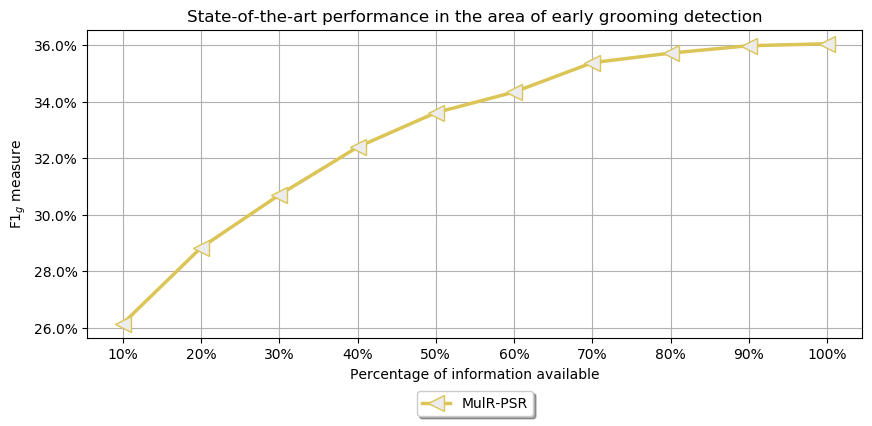

In [27]:
PATH = "../../Data/PJZC.pkl"
TE_DDRs,labels = calculating_preds(PATH,10)

# Testing with the PJZ dataset

Extracting conversations
%text:  (13822, 10)
labels:  13822 0
start_time_conversations:  13822 05:16
# participants:  (13822, 10) [2]
%int matrix:  (13822, 10) [0.625 0.375 0.    0.    0.   ]
++++++++++++++++++++++++++++++++++++++++
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
TE:  (13822, 14656)
TE_DDR:  (13822, 1660)
********************
RESULTS PER CHUNK: 
CLASSIFICATION FOR CHUNK: 1
F1 mesure with  10 % of the information available:  0.5719
CLASSIFICATION FOR C

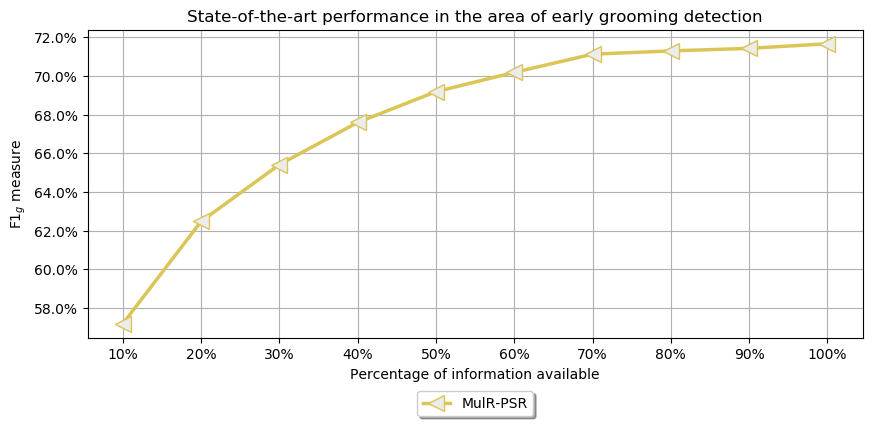

In [28]:
PATH = "../../Data/PJZ.pkl"
TE_DDRs,labels = calculating_preds(PATH,10)